### Importing Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


### Reading the file

In [4]:
bank_train = pd.read_csv("bank-full.csv",delimiter = ";")
bank_test = pd.read_csv("bank.csv", delimiter =";")


In [5]:
# A view of the dataset
bank_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Finding missing values in the dataset

In [7]:
# indicates there are no missing values
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


summarizing the dataset

In [9]:
# getting an overview of the columns
# STD of the various numerical columns may indicate the presence of outliers. the higher the STD the higher the chances of outliers
bank_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [10]:
# a detailed description of categorical columns 
# the unique indicates the number unique variables in the column
# We are able to see the unique variables with the highest frequency. 
# taking a look at the default column,there is an obvious imbalance regarding the variables where we have no appearing 44396 times out of 45211 
bank_train.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


### Exploratory Data Analysis

#### Target Distribution

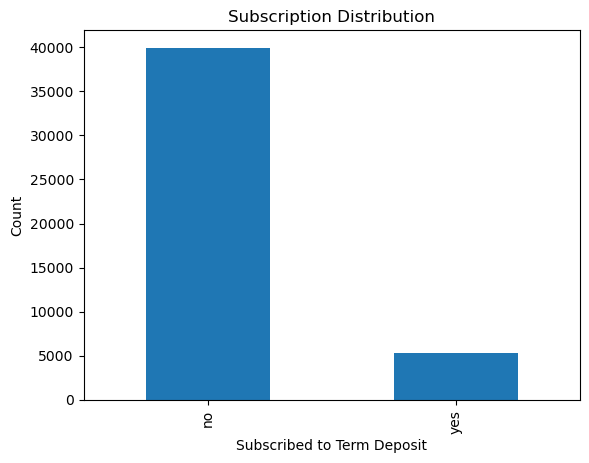

In [13]:
# a view of the target distribution for column y
# there is a significant imbalance with and we will need to adjust the weights to aid train our model
bank_train['y'].value_counts().plot(kind='bar')
plt.title('Subscription Distribution')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.show()

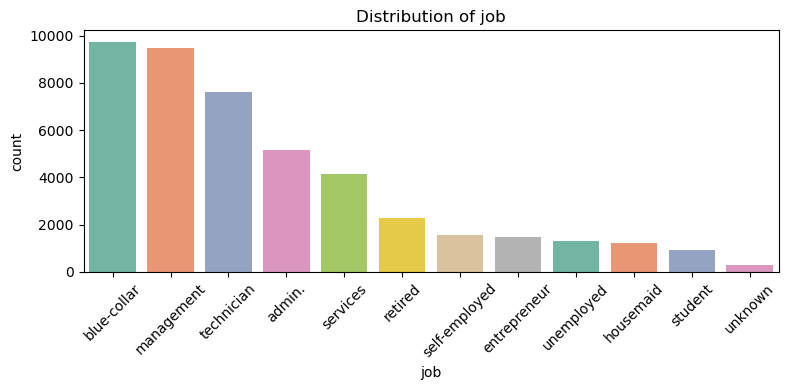

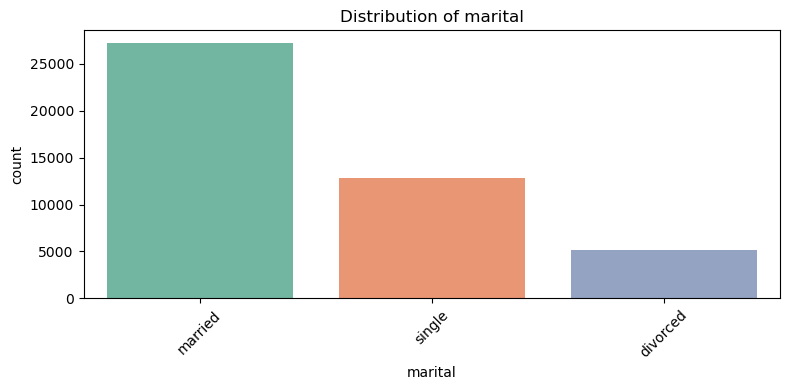

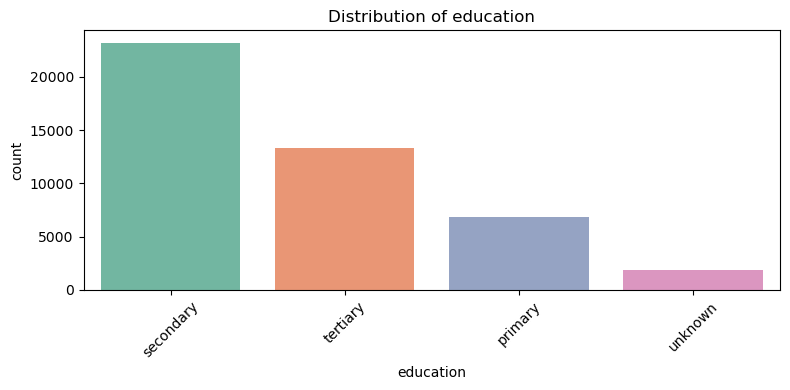

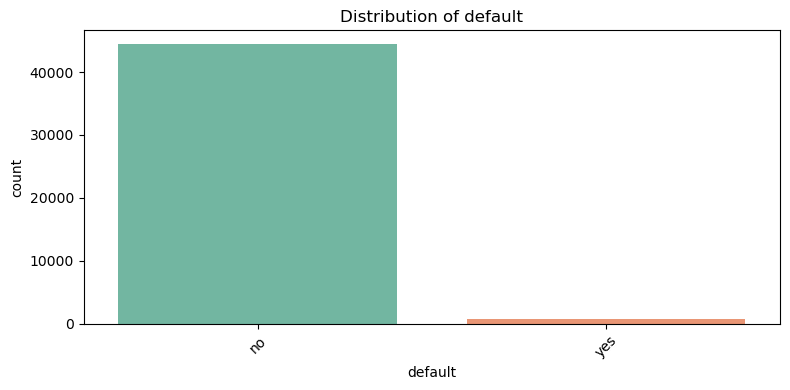

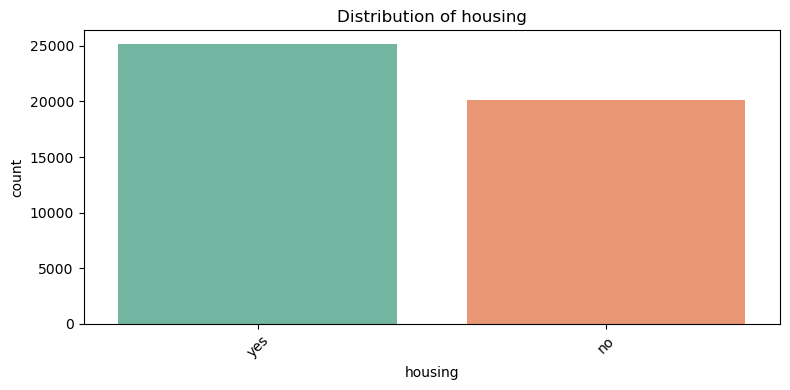

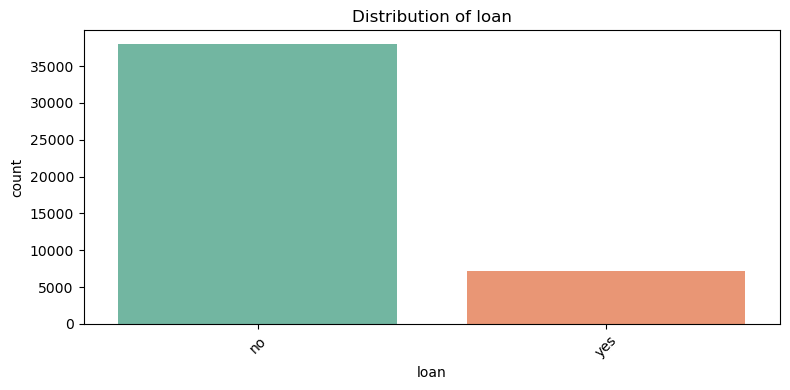

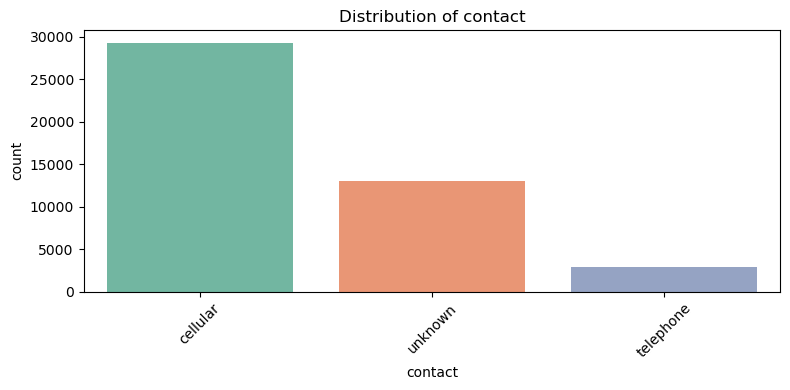

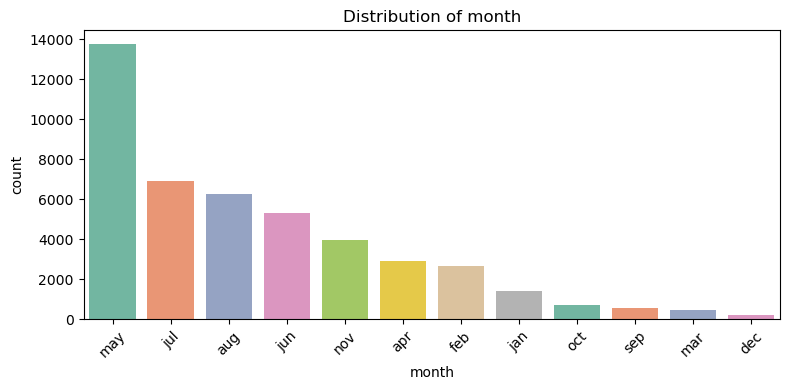

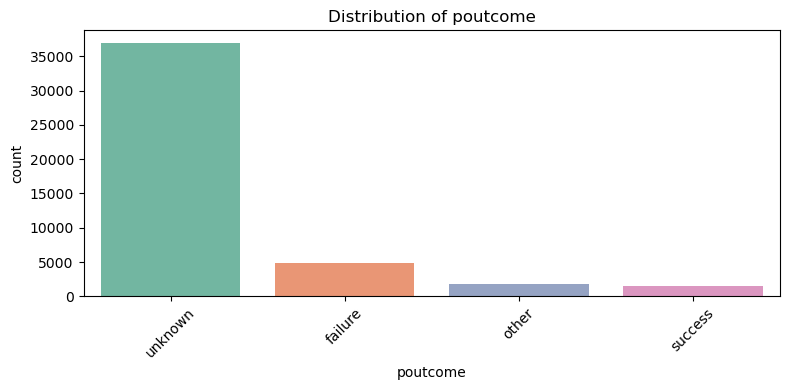

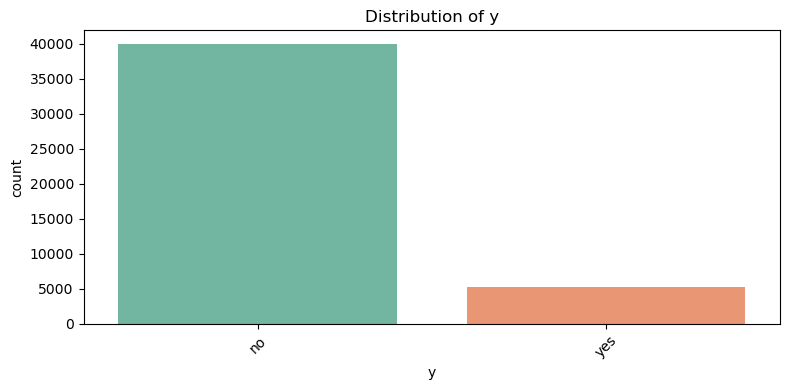

In [14]:
# Separate columns
categorical_cols = bank_train.select_dtypes(include='object').columns
numerical_cols = bank_train.select_dtypes(include=['int64', 'float64']).columns

#Categorical Columns Distribution
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=bank_train, x=col, order=bank_train[col].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


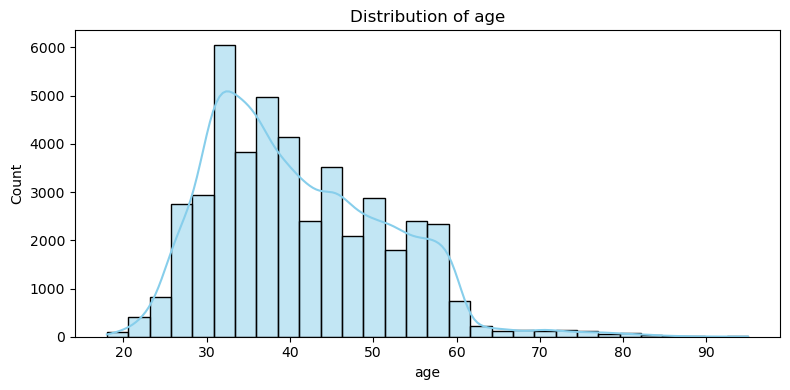

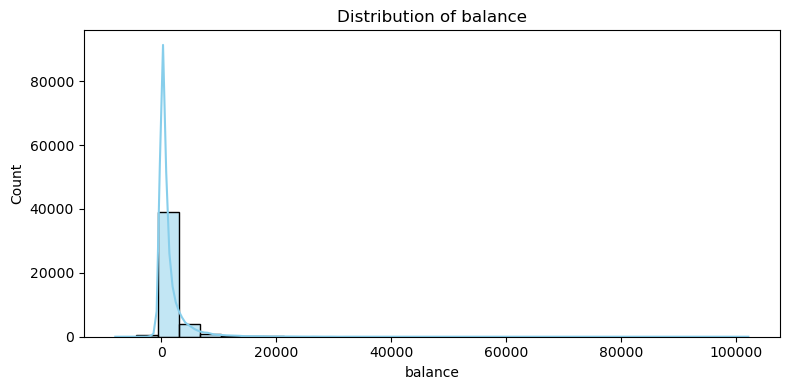

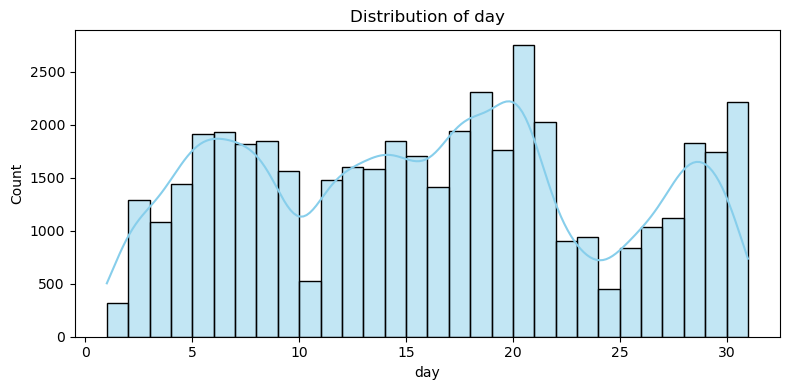

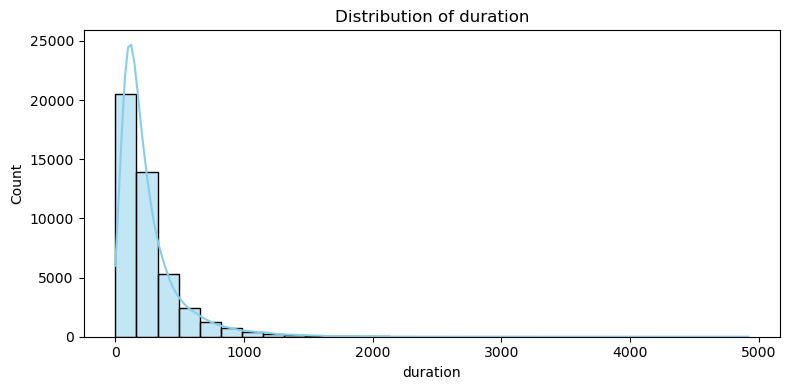

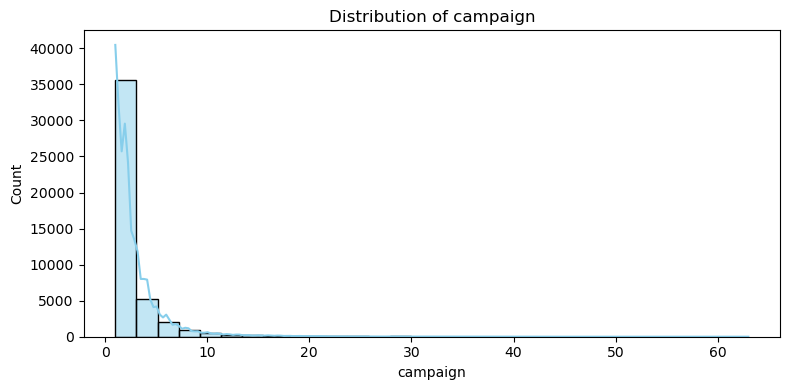

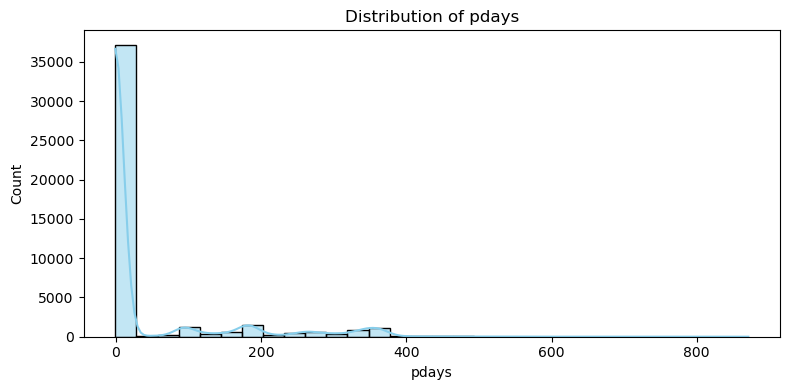

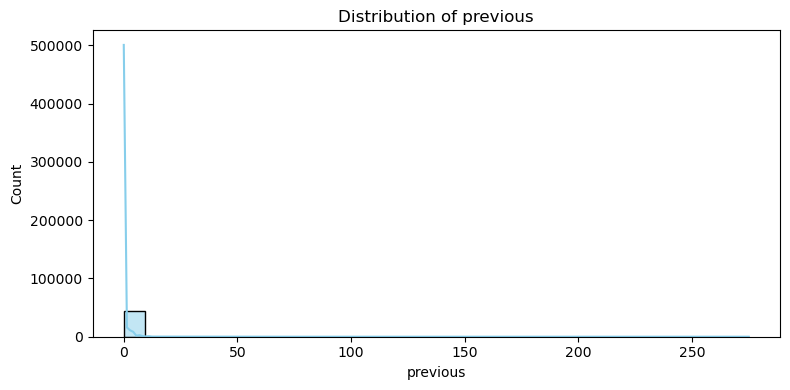

In [15]:
#Numerical Columns Distribution
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=bank_train, x=col, bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

### Feature Engineering

In [17]:
# creating new features

# creating new column(was previously contacted)
bank_train['was_previously_contacted'] = (bank_train['pdays'] != -1).astype(int)

# creating new column(age group)
bank_train['age_group'] = pd.cut(bank_train['age'], bins=[17, 25, 35, 45, 55, 65, 100], 
                                 labels=['18–25', '26–35', '36–45', '46–55', '56–65', '66+'])
#creating new column(balance group)
bank_train['balance_group'] = pd.cut(bank_train['balance'], 
                                     bins=[-10000, 0, 1000, 5000, 10000, 100000],
                                     labels=['Debt', 'Low', 'Medium', 'High', 'Very High'])


In [18]:
# dropping the age and pdays column as new columns were created for that and will not be needed in the training
bank_train = bank_train.drop(columns=['age','pdays'])

#### Encoding categorical columns


In [20]:
# encoding the categorical columns would change the datatypes into integers to be used for training.
bank_train.columns

Index(['job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'y', 'was_previously_contacted', 'age_group',
       'balance_group'],
      dtype='object')

In [21]:
bank_train.dtypes

job                           object
marital                       object
education                     object
default                       object
balance                        int64
housing                       object
loan                          object
contact                       object
day                            int64
month                         object
duration                       int64
campaign                       int64
previous                       int64
poutcome                      object
y                             object
was_previously_contacted       int32
age_group                   category
balance_group               category
dtype: object

In [22]:
# Define columns with 'yes'/'no' values that can be mapped to 1/0
binary_columns = ['default', 'housing', 'loan', 'y']

# Convert 'yes'/'no' to 1/0
for col in binary_columns:
    bank_train[col] = bank_train[col].map({'yes': 1, 'no': 0})

# Optional: Convert categorical columns to category codes
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_group', 'balance_group']

for col in categorical_columns:
    bank_train[col] = bank_train[col].astype('category').cat.codes

print(bank_train.dtypes)

job                          int8
marital                      int8
education                    int8
default                     int64
balance                     int64
housing                     int64
loan                        int64
contact                      int8
day                         int64
month                        int8
duration                    int64
campaign                    int64
previous                    int64
poutcome                     int8
y                           int64
was_previously_contacted    int32
age_group                    int8
balance_group                int8
dtype: object


In [23]:
bank_train

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,was_previously_contacted,age_group,balance_group
0,4,1,2,0,2143,1,0,2,5,8,261,1,0,3,0,0,4,2
1,9,2,1,0,29,1,0,2,5,8,151,1,0,3,0,0,2,1
2,2,1,1,0,2,1,1,2,5,8,76,1,0,3,0,0,1,1
3,1,1,3,0,1506,1,0,2,5,8,92,1,0,3,0,0,3,2
4,11,2,3,0,1,0,0,2,5,8,198,1,0,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,9,1,2,0,825,0,0,0,17,9,977,3,0,3,1,0,3,1
45207,5,0,0,0,1729,0,0,0,17,9,456,2,0,3,1,0,5,2
45208,5,1,1,0,5715,0,0,0,17,9,1127,5,3,2,1,1,5,3
45209,1,1,1,0,668,0,0,1,17,9,508,4,0,3,0,0,4,1


In [25]:
# start data cleaning for the dataset for testing
bank_test.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [28]:
# Creating binary feature from pdays
bank_test['was_previously_contacted'] = (bank_test['pdays'] != -1).astype(int)

# creating Age groups
bank_test['age_group'] = pd.cut(
    bank_test['age'],
    bins=[17, 25, 35, 45, 55, 65, 100],
    labels=['18–25', '26–35', '36–45', '46–55', '56–65', '66+']
)

# Balance group bins
bank_test['balance_group'] = pd.cut(
    bank_test['balance'],
    bins=[-np.inf, 0, 1000, 3000, np.inf],
    labels=['Low', 'Medium', 'High', 'Very High']
)


In [29]:
bank_test.dtypes

age                            int64
job                           object
marital                       object
education                     object
default                       object
balance                        int64
housing                       object
loan                          object
contact                       object
day                            int64
month                         object
duration                       int64
campaign                       int64
pdays                          int64
previous                       int64
poutcome                      object
y                             object
was_previously_contacted       int32
age_group                   category
balance_group               category
dtype: object

In [30]:
#dropping the duration, age, pdays,day column as we did for the bank_train dataset
bank_test = bank_test.drop(columns=['age','pdays',])

In [31]:
# Define columns with 'yes'/'no' values that can be mapped to 1/0
binary_columns = ['default', 'housing', 'loan', 'y']

# Convert 'yes'/'no' to 1/0
for col in binary_columns:
    bank_test[col] = bank_test[col].map({'yes': 1, 'no': 0})

# Optional: Convert categorical columns to category codes
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_group', 'balance_group']

for col in categorical_columns:
    bank_test[col] = bank_test[col].astype('category').cat.codes

print(bank_test.dtypes)


job                          int8
marital                      int8
education                    int8
default                     int64
balance                     int64
housing                     int64
loan                        int64
contact                      int8
day                         int64
month                        int8
duration                    int64
campaign                    int64
previous                    int64
poutcome                     int8
y                           int64
was_previously_contacted    int32
age_group                    int8
balance_group                int8
dtype: object


In [24]:
#feature selection
X_train = bank_train.drop(columns=['y'])
y_train = bank_train['y']

In [26]:
# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create dictionary
weights = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", weights)

Computed Class Weights: {0: 0.566241671258955, 1: 4.274059368500661}


In [27]:
# adjusting the weights of the column y as that is our target column.

# Check class distribution in training target
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

y
0    39922
1     5289
Name: count, dtype: int64
y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


In [32]:
#seperating y_yes from bank_test
if 'y' in bank_test.columns:
    X_test = bank_test.drop(columns=['y'])
    y_test = bank_test['y']
else:
    X_test = bank_test.copy()
    y_test = None 

### Model Training

In [34]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight=weights)
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight=weights, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False,class_weight=weights, eval_metric='logloss')
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 0.566241671258955, 1: 4.274059368500661},
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Evaluating model

In [65]:
# without weights
models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"🔹 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)


🔹 Logistic Regression
Accuracy: 0.7934085379340854
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      4000
           1       0.33      0.79      0.47       521

    accuracy                           0.79      4521
   macro avg       0.65      0.79      0.67      4521
weighted avg       0.89      0.79      0.83      4521

--------------------------------------------------
🔹 Random Forest
Accuracy: 0.9997788099977881
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521

--------------------------------------------------
🔹 XGBoost
Accuracy: 0.9484627294846273
Classification Report:
               precision    recall  f1

From this, it is seen that the best model is the XGBoost model. it is well balanced and has a good balance between precision and recall.

In [74]:
#predicting using the class weight
y_pred = lr.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4000
           1       0.33      0.79      0.47       521

    accuracy                           0.79      4521
   macro avg       0.65      0.79      0.67      4521
weighted avg       0.89      0.79      0.83      4521



The data has too many people not subscribing which is not ideal since it will teach that machine to predict more nos than yes. hence we made one class have more weight or importance so that the model pays attention to it. We made the yes 7 times more important to match up the nos. and trained the model with those weights.